In [1]:
import torch
import torch.nn as nn
import numpy as np
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import shap
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda:0")

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [5]:
batch_size=8

In [6]:
resnet18 = models.resnet18(pretrained=True)

In [7]:
# for param in model.parameters():
#     param.requires_grad = False
#     Replace the last fully-connected layer
#     Parameters of newly constructed modules have requires_grad=True by default
resnet18.fc = nn.Linear(512, 10) # assuming that the fc7 layer has 512 neurons, otherwise change it

In [8]:
resnet18.type(torch.cuda.FloatTensor)
resnet18.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = torch.optim.Adam(resnet18.parameters())

In [9]:
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs, step_size):    
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=0.5)
    loss_history = []
    train_history = []
    val_history = []
    try:
        for epoch in range(num_epochs):
            model.train() # Enter train mode

            loss_accum = 0
            correct_samples = 0
            total_samples = 0
            for i_step, (x, y) in enumerate(train_loader):          
                x_gpu = x.to(device)
                if type(y) == int:
                    y = torch.tensor(y.float32)
    #             y = y.unsqueeze(1)

                y_gpu = y.to(device)
                prediction = model(x_gpu)    
                loss_value = loss(prediction, y_gpu)
                optimizer.zero_grad()
                loss_value.backward()
                optimizer.step()

                _, indices = torch.max(prediction, 1)
                correct_samples += torch.sum(indices == y_gpu)
                total_samples += y.shape[0]

                loss_accum += loss_value

            ave_loss = loss_accum / i_step
            train_accuracy = float(correct_samples) / total_samples
            val_accuracy = compute_accuracy(model, val_loader)

            loss_history.append(float(ave_loss))
            train_history.append(train_accuracy)
            val_history.append(val_accuracy)

            print(f"Average loss: {ave_loss:.3f}, Train accuracy: {train_accuracy:.3f}  | Test accuracy: {val_accuracy:.3f}")
    except KeyboardInterrupt:
        pass
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    
    total_samples = 0
    correct_samples = 0
    for x, y in loader:
        x_gpu = x.to(device)
        if type(y) == int:
            y = torch.tensor(y.float32)
        y_gpu = y.to(device)
        prediction = model(x_gpu)
        indices = torch.argmax(prediction, 1)
        correct_samples += torch.sum(indices == y_gpu)
        total_samples += y_gpu.shape[0]
    
    return float(correct_samples) / total_samples

def get_predictions(model, loader):
    model.eval()
    preds = []
    target = []
    for x, y in loader:
        y = y.unsqueeze(1)
        x_gpu = x.to(device)
        prediction = model(x_gpu)
        preds.append(prediction.cpu().detach().numpy())
        target.append(y)
    preds = np.concatenate(preds, axis=0).reshape(-1)
    target = np.concatenate(target, axis=0).reshape(-1)
    return target, preds

    
def compute_scores(model, loader):
    target, preds = get_predictions(model, loader)
    r2 = compute_r2(target, preds)
    mae = mean_absolute_error(target, preds)
    return r2, mae

In [ ]:
loss_history, train_history, val_history = train_model(resnet18, trainloader, testloader, loss, optimizer, 20, 3)

Average loss: 2.247, Train accuracy: 0.184  | Test accuracy: 0.331
Average loss: 1.895, Train accuracy: 0.304  | Test accuracy: 0.381
Average loss: 1.651, Train accuracy: 0.402  | Test accuracy: 0.492
Average loss: 1.497, Train accuracy: 0.462  | Test accuracy: 0.521
Average loss: 1.375, Train accuracy: 0.512  | Test accuracy: 0.522
Average loss: 1.287, Train accuracy: 0.546  | Test accuracy: 0.603
Average loss: 1.204, Train accuracy: 0.576  | Test accuracy: 0.621
Average loss: 1.153, Train accuracy: 0.597  | Test accuracy: 0.568
Average loss: 1.115, Train accuracy: 0.613  | Test accuracy: 0.611
Average loss: 1.078, Train accuracy: 0.625  | Test accuracy: 0.605
Average loss: 1.064, Train accuracy: 0.632  | Test accuracy: 0.615
Average loss: 1.079, Train accuracy: 0.624  | Test accuracy: 0.600
Average loss: 1.033, Train accuracy: 0.641  | Test accuracy: 0.635
Average loss: 0.996, Train accuracy: 0.656  | Test accuracy: 0.630


In [12]:
# torch.save(resnet18.state_dict(), 'Torch_models/resnet18.pt')

In [10]:
resnet18.load_state_dict(torch.load('Torch_models/resnet18.pt',device))

<All keys matched successfully>

## Shap

In [11]:
explset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                       download=True)

Files already downloaded and verified


In [12]:
normalization = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

In [14]:
# python function to get model output; replace this function with your own model function.
resnet18.eval()
def f(x):
#     print(x.shape)
    x = x.reshape(-1, 3, 32, 32)
    rez = []
    for img in x:
#         print(img.shape)
        tmp = torch.from_numpy(img).float()
        tmp = normalization(tmp)
        x_gpu = tmp.to(device)
        x_gpu = torch.unsqueeze(x_gpu, 0)
        return resnet18(x_gpu)
        rez.append(torch.softmax(resnet18(x_gpu)).cpu().detach().numpy())
    return np.concatenate(rez, axis=0)

# define a masker that is used to mask out partitions of the input image.
masker = shap.maskers.Image("inpaint_telea", (32, 32, 3))


# create an explainer with model and image masker
explainer = shap.Explainer(f, masker, output_names=classes)

# here we explain two images using 500 evaluations of the underlying model to estimate the SHAP values
shap_values = explainer(np.array(explset.__getitem__(8)[0].getdata()).reshape(32, 32, 3)[np.newaxis, :].astype('float32'), 
                        max_evals=400, batch_size=500, outputs=shap.Explanation.argsort.flip[:10])

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [ ]:
# output with shap values
shap.image_plot(shap_values)

In [106]:
im = np.array(explset.__getitem__(6)[0].getdata()).reshape(32,32,3)

In [107]:
torch.from_numpy(im)

tensor([[[164, 206,  84],
         [105, 140,  61],
         [118, 148, 101],
         ...,
         [109, 147,  73],
         [108, 147,  69],
         [ 91, 129,  57]],

        [[167, 213,  84],
         [116, 160,  49],
         [ 72, 109,  43],
         ...,
         [105, 142,  79],
         [105, 142,  72],
         [ 89, 127,  57]],

        [[140, 191,  65],
         [142, 193,  66],
         [119, 163,  79],
         ...,
         [104, 139,  84],
         [ 84, 120,  58],
         [ 78, 115,  49]],

        ...,

        [[139, 148,  81],
         [142, 155,  74],
         [135, 156,  72],
         ...,
         [ 89, 134,  28],
         [ 97, 148,  24],
         [126, 176,  49]],

        [[163, 157,  85],
         [153, 164,  82],
         [146, 164,  90],
         ...,
         [ 85, 130,  19],
         [ 98, 148,  27],
         [127, 178,  48]],

        [[183, 153, 102],
         [176, 182, 116],
         [154, 154, 100],
         ...,
         [ 94, 134,  29],
        

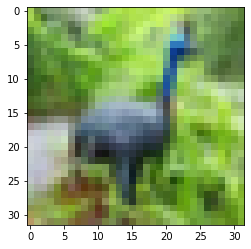

In [108]:
# plt.figure(figsize=(10, 10))
plt.imshow(np.array(explset.__getitem__(6)[0].getdata()).reshape(32,32,3))

In [61]:
a = next(iter(trainloader))

In [64]:
torch.unsqueeze(a[0], 0).shape

torch.Size([1, 4, 3, 32, 32])

In [36]:
r = f(np.array(explset.__getitem__(111)[0].getdata()).reshape(32,32,3)[np.newaxis, :])

In [37]:
r

tensor([[-39688.0352, -52476.5234, -47066.0391, -41027.1914, -45766.4102,
         -45686.1289, -48292.2773, -40075.9180, -47280.7188, -43033.6328]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [22]:
torch.softmax(torch(ten), -1)

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)

In [65]:
np.array(explset.__getitem__(6)[0].getdata()

SyntaxError: unexpected EOF while parsing (Temp/ipykernel_13588/1591302973.py, line 1)

In [70]:
np.array(explset.__getitem__(6)[0].getdata()).reshape(3, 32, 32)[np.newaxis, :].astype('float32')

array([[[[164., 206.,  84., ..., 163., 140., 169.],
         [116., 154., 196., ..., 243., 110., 203.],
         [243.,  97., 188., ...,  91., 129.,  57.],
         ...,
         [ 96., 152., 163., ...,  92., 118.,  68.],
         [ 55.,  92.,  37., ...,  29.,  93., 153.],
         [ 41., 124., 177., ...,  89., 149.,  56.]],

        [[117., 137., 171., ..., 111., 142.,  79.],
         [ 56.,  91.,  33., ...,  40., 122., 178.],
         [ 67., 146., 197., ...,  82., 155.,  69.],
         ...,
         [ 52.,  39.,  44., ...,  91.,  40., 103.],
         [149.,  55., 117., ..., 143., 183.,  75.],
         [198., 205., 208., ...,  75.,  23.,  21.]],

        [[ 24.,  17.,  20., ..., 119.,  47., 139.],
         [187.,  88., 115., ..., 161., 197., 107.],
         [195., 203., 209., ...,  53.,  44.,  56.],
         ...,
         [183., 153., 102., ...,  71., 110.,  93.],
         [ 67., 118., 128., ..., 169.,  83., 152.],
         [192., 106., 157., ..., 122., 170.,  44.]]]], dtype=float32)